In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import glob
from itertools import product
import itertools

import altair as alt
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sourmash import signature as sig
from tqdm import tqdm

%matplotlib inline

In [10]:
import common

figure_folder = common.get_figure_folder()
! mkdir -p $figure_folder
figure_folder

'../figures/090_compare_bladder_10x_num_hashes=10000'

In [7]:
! aws s3 ls s3://olgabot-maca/10x/sourmash_compute/10X_P4_3/

                           PRE scaled=0_num_hashes=10000/
                           PRE scaled=1000_num_hashes=0/


In [11]:
! aws s3 sync s3://olgabot-maca/10x/sourmash_compute/10X_P4_3/ /home/olga/scratch/maca/10x/sourmash_compute/10X_P4_3/

download: s3://olgabot-maca/10x/sourmash_compute/10X_P4_3/scaled=1000_num_hashes=0/possorted_genome_bam.sig to ../../../scratch/maca/10x/sourmash_compute/10X_P4_3/scaled=1000_num_hashes=0/possorted_genome_bam.sig
download: s3://olgabot-maca/10x/sourmash_compute/10X_P4_3/scaled=0_num_hashes=10000/possorted_genome_bam.sig to ../../../scratch/maca/10x/sourmash_compute/10X_P4_3/scaled=0_num_hashes=10000/possorted_genome_bam.sig


In [17]:
sig_folder = '/home/olga/scratch/maca/10x/sourmash_compute/10X_P4_3/'

scaled1000_suffix = 'scaled=1000_num_hashes=0/possorted_genome_bam.sig'
num_hashes10000_suffix = 'scaled=0_num_hashes=10000/possorted_genome_bam.sig'

! ls -lha $sig_folder/*/*.sig

-rw-rw-r-- 1 olga olga 227M Nov  3 17:22 /home/olga/scratch/maca/10x/sourmash_compute/10X_P4_3//scaled=0_num_hashes=10000/possorted_genome_bam.sig
-rw-rw-r-- 1 olga olga  81M Nov  3 17:22 /home/olga/scratch/maca/10x/sourmash_compute/10X_P4_3//scaled=1000_num_hashes=0/possorted_genome_bam.sig


In [21]:
%time scaled1000_siglist = list(sig.load_signatures(f'{sig_folder}{scaled1000_suffix}'))

...sig loading 147


CPU times: user 1min 32s, sys: 9.22 s, total: 1min 42s
Wall time: 1min 42s


In [24]:
%time num_hashes10000_siglist = list(sig.load_signatures(f'{sig_folder}{num_hashes10000_suffix}'))

...sig loading 147


CPU times: user 4min 44s, sys: 31.4 s, total: 5min 15s
Wall time: 5min 15s


In [25]:
for s in scaled1000_siglist[:10]:
    print('---')
    print(f's.minhash.ksize: {s.minhash.ksize}')
    print(f's.minhash.is_protein: {s.minhash.is_protein}')

---
s.minhash.ksize: 21
s.minhash.is_protein: True
---
s.minhash.ksize: 21
s.minhash.is_protein: False
---
s.minhash.ksize: 27
s.minhash.is_protein: True
---
s.minhash.ksize: 27
s.minhash.is_protein: False
---
s.minhash.ksize: 33
s.minhash.is_protein: True
---
s.minhash.ksize: 33
s.minhash.is_protein: False
---
s.minhash.ksize: 51
s.minhash.is_protein: True
---
s.minhash.ksize: 51
s.minhash.is_protein: False
---
s.minhash.ksize: 21
s.minhash.is_protein: True
---
s.minhash.ksize: 21
s.minhash.is_protein: False


In [41]:
from sourmash_utils import filter_siglist
from downsample_hashes import compare_num_hashes, subset_ksize_moltype_and_compare_numhashes, compare_downsampled

In [35]:

%time siglist_k27_dna = filter_siglist(num_hashes10000_siglist, 27, 'DNA')
siglist_k27_dna = siglist_k27_dna[:10]
len(siglist_k27_dna)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 607 µs


10

In [36]:
names = [s.name() for s in siglist_k27_dna]
names

['cell_ontology_class:bladder_urothelial_cell|tissue:Bladder|free_annotation:Basal_bladder_epithelial_cell|mouse_id:3-M-8|10X_P4_3_AGCGGTCTCTGAGTGT',
 'cell_ontology_class:bladder_urothelial_cell|tissue:Bladder|free_annotation:Basal_bladder_epithelial_cell|mouse_id:3-M-8|10X_P4_3_AGGTCCGAGGACACCA',
 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_AACCGCGTCCAACCAA',
 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_AGAGCTTTCTGTTGAG',
 'cell_ontology_class:bladder_urothelial_cell|tissue:Bladder|free_annotation:Basal_bladder_epithelial_cell|mouse_id:3-M-8|10X_P4_3_TAAGCGTAGAAACCGC',
 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_GATTCAGCAGTGGAGT',
 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_GCGAGAATCCCTCTTT',
 'cell_ontolog

In [43]:
num_hashess = 100, 200, 500, 1000, 2000, 5000, 10000

dfs = []

for num_hashes in num_hashess:
    print(f'num_hashes: {num_hashes}')
    df = compare_downsampled(siglist_k27_dna, num_hashes=num_hashes, names=names)
    dfs.append(df)
similarity_k27_dna = pd.concat(dfs)
print(similarity_k27_dna.shape)
similarity_k27_dna.head()

num_hashes: 100
num_hashes: 200


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


num_hashes: 500
num_hashes: 1000
num_hashes: 2000
num_hashes: 5000
num_hashes: 10000
(630, 5)


,cell1,cell2,similarity,num_hashes,time_seconds
1,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_urothelial_cell|ti...,0.09,100,0.001967
2,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.10,100,0.001967
3,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.06,100,0.001967
4,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_urothelial_cell|ti...,0.12,100,0.001967
5,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.04,100,0.001967


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


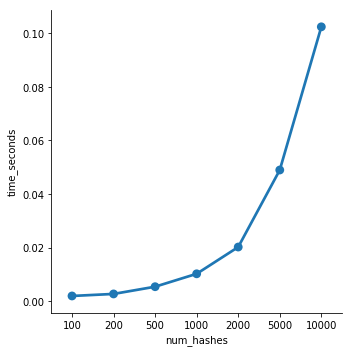

In [46]:
import seaborn as sns

sns.factorplot(data=similarity_k27_dna, x='num_hashes', y='time_seconds')

In [61]:


import altair as alt
alt.renderers.enable('notebook')



alt.Chart(similarity_k27_dna).mark_line(point=True).encode(x='num_hashes', y='time_seconds')

~8 signatures/cell, so this should be around 10 cells

In [49]:
num_hashes10000_siglist_subset = num_hashes10000_siglist[:100]

In [52]:
molecules = 'DNA', 'protein'
ksizes = 21, 27, 33, 51
dfs = []

num_hashess = 100, 200, 500, 1000, 2000, 5000, 10000


for molecule, ksize in itertools.product(molecules, ksizes):
    print('---')
    print(f'molecule: {molecule}, ksize: {ksize}')
    df = subset_ksize_moltype_and_compare_numhashes(num_hashes10000_siglist_subset, ksize, molecule,
                                                    num_hashes_to_downsample=num_hashess)
    print('\tdf.shape')
    dfs.append(df)
similarity_ksize_moltype = pd.concat(dfs)
print(similarity_ksize_moltype.shape)
similarity_ksize_moltype.head()

---
molecule: DNA, ksize: 21
	num_hashes: 100
	num_hashes: 200


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(1092, 5)
	df.shape
---
molecule: DNA, ksize: 27
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(1092, 5)
	df.shape
---
molecule: DNA, ksize: 33
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(924, 5)
	df.shape
---
molecule: DNA, ksize: 51
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(924, 5)
	df.shape
---
molecule: protein, ksize: 21
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(1092, 5)
	df.shape
---
molecule: protein, ksize: 27
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
(1092, 5)
	df.shape
---
molecule: prote

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
1,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_urothelial_cell|ti...,0.06,100,0.003446,21,DNA
2,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.06,100,0.003446,21,DNA
3,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.07,100,0.003446,21,DNA
4,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_urothelial_cell|ti...,0.07,100,0.003446,21,DNA
5,cell_ontology_class:bladder_urothelial_cell|ti...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.01,100,0.003446,21,DNA


In [56]:
cell1 = 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_AACCGCGTCCAACCAA'
cell1_similarity = similarity_ksize_moltype.query('(cell1 == @cell1) & (cell2 != @cell1)')
cell1_similarity.head()

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.06,100,0.003446,21,DNA
27,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.05,100,0.003446,21,DNA
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.08,100,0.003446,21,DNA
30,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.03,100,0.003446,21,DNA
31,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.02,100,0.003446,21,DNA


<bound method Grid.set of <seaborn.axisgrid.FacetGrid object at 0x7f495430dd30>>

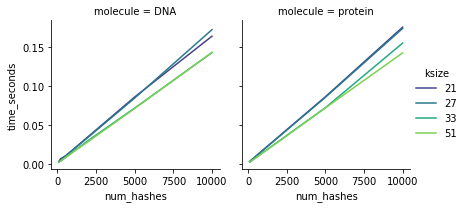

In [60]:
g = sns.FacetGrid(cell1_similarity, hue='ksize', col='molecule', palette='viridis')
g.map(plt.plot, 'num_hashes', 'time_seconds')
g.add_legend()
g.set

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


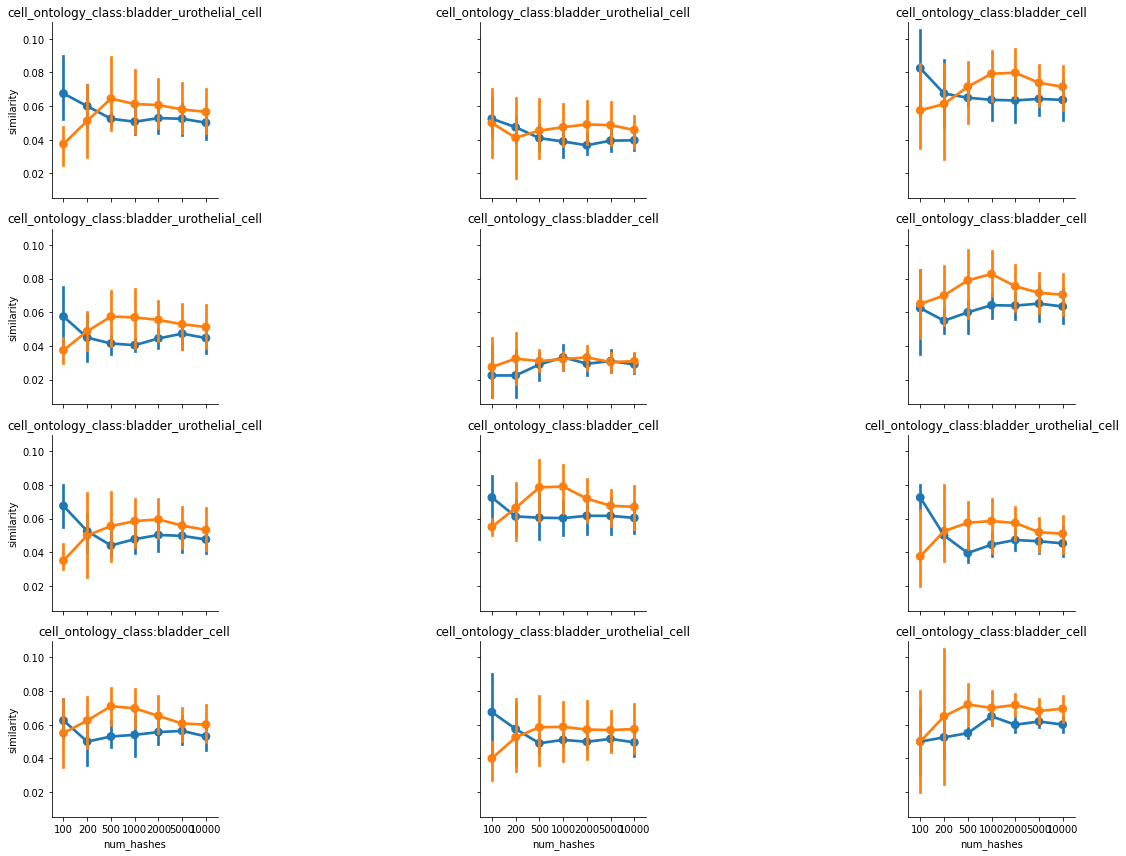

In [65]:
g = sns.FacetGrid(cell1_similarity, col='cell2', aspect=2, col_wrap=3, hue='molecule')
g.map(sns.pointplot, 'num_hashes', 'similarity')
for ax in g.axes.flat:
    title = ax.get_title()
    new_title = title.split('cell2 = ')[1].split('|')[0]
    ax.set_title(new_title)
g.fig.tight_layout()

Compare vs another bladder cell

In [66]:


cell2 = 'cell_ontology_class:bladder_cell|tissue:Bladder|free_annotation:Bladder_mesenchymal_cell|mouse_id:3-M-8|10X_P4_3_AGAGCTTTCTGTTGAG'
cell1_cell2_similarity = cell1_similarity.query('cell2 == @cell2')
cell1_cell2_similarity.head()

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.080,100,0.003446,21,DNA
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.070,200,0.006745,21,DNA
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.076,500,0.010185,21,DNA
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.081,1000,0.018419,21,DNA
29,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,0.080,2000,0.035280,21,DNA


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


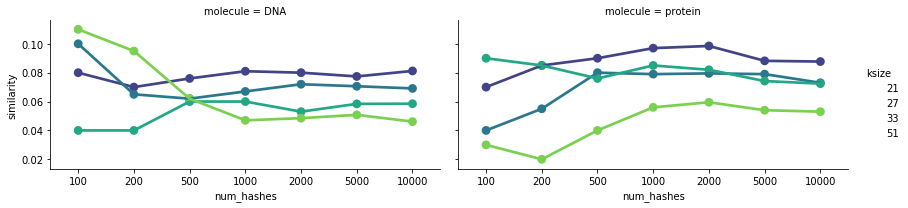

In [70]:
g = sns.FacetGrid(cell1_cell2_similarity, col='molecule', aspect=2, hue='ksize', palette='viridis')
g.map(sns.pointplot, 'num_hashes', 'similarity')
g.fig.tight_layout()
g.add_legend()

Vs a bladder urothelial cell

In [71]:
cell3 = 'cell_ontology_class:bladder_urothelial_cell|tissue:Bladder|free_annotation:Basal_bladder_epithelial_cell|mouse_id:3-M-8|10X_P4_3_AGCGGTCTCTGAGTGT'
cell1_cell3_similarity = cell1_similarity.query('cell2 == @cell3')
cell1_cell3_similarity.head()

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.0600,100,0.003446,21,DNA
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.0450,200,0.006745,21,DNA
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.0560,500,0.010185,21,DNA
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.0650,1000,0.018419,21,DNA
26,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_urothelial_cell|ti...,0.0665,2000,0.035280,21,DNA


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


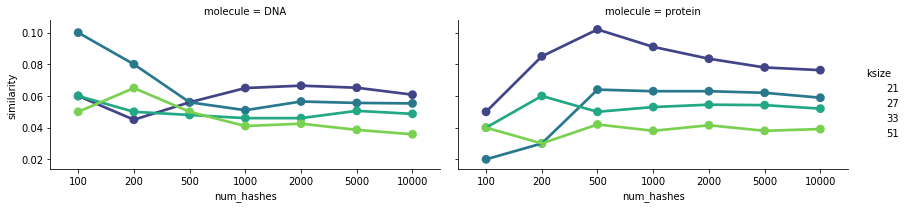

In [72]:

g = sns.FacetGrid(cell1_cell3_similarity, col='molecule', aspect=2, hue='ksize', palette='viridis')
g.map(sns.pointplot, 'num_hashes', 'similarity')
g.fig.tight_layout()
g.add_legend()

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


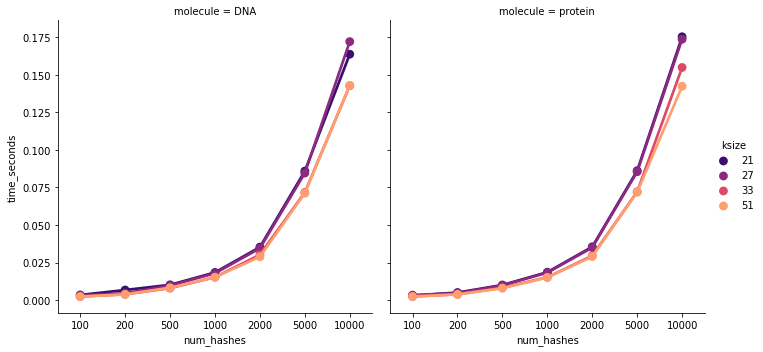

In [127]:
import seaborn as sns

sns.factorplot(data=similarity_ksize_moltype, x='num_hashes', y='time_seconds', 
               col='molecule', hue='ksize', palette='magma')

## Plot difference from "True" similarity at maximum hashes

In [79]:
CELL_INDEX = ['cell1', 'cell2']

max_num_hashes = similarity_ksize_moltype.num_hashes.max()
true_similarity = similarity_ksize_moltype.query('num_hashes == @max_num_hashes')
true_similarity = true_similarity.set_index(CELL_INDEX).sort_index()
print(true_similarity.shape)
true_similarity.head()

(1152, 5)


similarity  \
cell1                                              cell2                                                            
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...      0.0812   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.0691   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.0585   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.0461   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.0877   

                                                                                                       num_hashes  \
cell1                                              cell2                                                            
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...       10000   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       10000   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       10000   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       10000   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       10000   

                                                                                                       time_seconds  \
cell1                                              cell2                                                              
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...      0.163661   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.172023   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.142710   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.142838   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.175248   

                                                                                                       ksize  \
cell1                                              cell2                                                       
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...     21   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     27   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     33   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     51   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     21   

                                                                                                      molecule  
cell1                                              cell2                                                        
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...  protein

In [80]:
test_similarity = similarity_ksize_moltype.query('num_hashes != @max_num_hashes')
test_similarity = test_similarity.set_index(CELL_INDEX).sort_index()
print(test_similarity.shape)
test_similarity.head()

(6912, 5)


similarity  \
cell1                                              cell2                                                            
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...       0.080   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       0.070   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       0.076   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       0.081   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...       0.080   

                                                                                                       num_hashes  \
cell1                                              cell2                                                            
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...         100   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...         200   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...         500   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...        1000   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...        2000   

                                                                                                       time_seconds  \
cell1                                              cell2                                                              
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...      0.003446   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.006745   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.010185   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.018419   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      0.035280   

                                                                                                       ksize  \
cell1                                              cell2                                                       
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...     21   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     21   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     21   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     21   
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...     21   

                                                                                                      molecule  
cell1                                              cell2                                                        
cell_ontology_class:bladder_cell|tissue:Bladder... cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA  
                                                   cell_ontology_class:bladder_cell|tissue:Bladder...      DNA

In [104]:
groupby = 'ksize', 'molecule', 'num_hashes'

similarity_difference = test_similarity.groupby(groupby).apply(lambda x: x['similarity'].subtract(true_similarity['similarity']))
similarity_difference = similarity_difference.unstack(level=[0, 1, 2]).reset_index()
similarity_difference = similarity_difference.rename(columns={0: 'similarity_difference'})
print(similarity_difference.shape)
similarity_difference.head()

(55296, 6)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  app.launch_new_instance()


,cell1,cell2,ksize,molecule,num_hashes,similarity_difference
0,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,21,DNA,100,-0.0012
1,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,21,DNA,200,-0.0112
2,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,21,DNA,500,-0.0052
3,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,21,DNA,1000,-0.0002
4,cell_ontology_class:bladder_cell|tissue:Bladde...,cell_ontology_class:bladder_cell|tissue:Bladde...,21,DNA,2000,-0.0012


In [ ]:
%%file 

def get_similarity_difference(similarity, groupby=('ksize', 'molecule', 'num_hashes')):
    """
    
    Parameters
    ----------
    similiarity : pandas.DataFrame
        tidy dataframe with "cell1", "cell2", "similarity" columns,
        plus groupby columns
    
    """
    CELL_INDEX = ['cell1', 'cell2']

    max_num_hashes = similarity.num_hashes.max()
    true_similarity = similarity.query('num_hashes == @max_num_hashes')
    true_similarity = true_similarity.set_index(CELL_INDEX).sort_index()

    test_similarity = similarity.query('num_hashes != @max_num_hashes')
    test_similarity = test_similarity.set_index(CELL_INDEX).sort_index()

    similarity_difference = test_similarity.groupby(groupby).apply(
        lambda x: x['similarity'].subtract(true_similarity['similarity']))
    similarity_difference = similarity_difference.unstack(level=[0, 1, 2]).reset_index()
    similarity_difference = similarity_difference.rename(columns={0: 'similarity_difference'})
    
    return similarity_difference

In [123]:
sns.pointplot?

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/matplotlib/artist.py:913: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(v)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/matplotlib/artist.py:913: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(v)


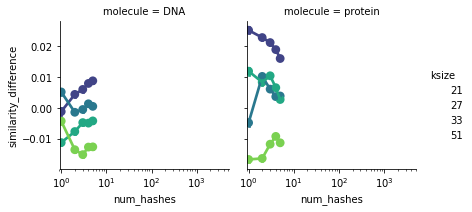

In [122]:
g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='viridis')
g.map(sns.pointplot, 'num_hashes', 'similarity_difference')
g.set(xlim=(-100, max_num_hashes*.52), xticks=xticks, xscale='log')
g.add_legend()

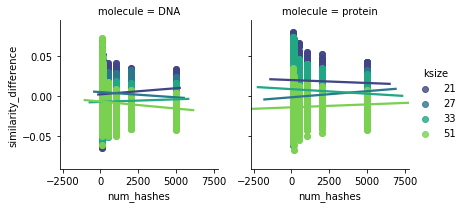

In [108]:
g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='viridis')
g.map(sns.regplot, 'num_hashes', 'similarity_difference')
g.add_legend()

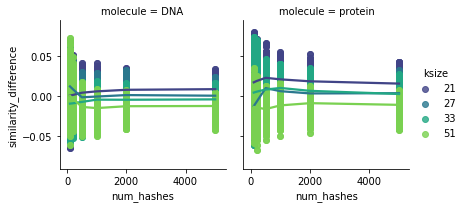

In [111]:
g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='viridis')
g.map(sns.regplot, 'num_hashes', 'similarity_difference',  lowess=True)
g.add_legend()

In [116]:
num_hashess

(100, 200, 500, 1000, 2000, 5000, 10000)

In [117]:
xticks = similarity_difference['num_hashes'].unique()

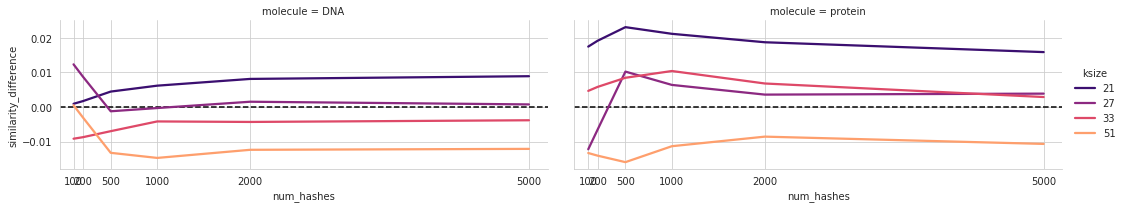

In [134]:
sns.set_style('whitegrid')

g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='magma', aspect=2.5)
g.map(sns.regplot, 'num_hashes', 'similarity_difference',  lowess=True, scatter=False)
g.set(xlim=(-50, max_num_hashes*.52), xticks=xticks)
for ax in g.axes.flat:
    xmin, xmax = ax.get_xlim()
    ax.hlines(0, xmin, xmax, color='k', linestyle='--')
g.add_legend()

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


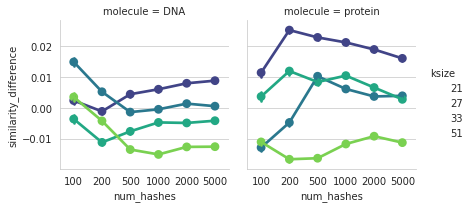

In [136]:
g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='viridis')
# g.map(sns.regplot, 'num_hashes', 'similarity_difference',  lowess=True, scatter=False)
g.map(sns.pointplot, 'num_hashes', 'similarity_difference')
# g.set(xlim=(-100, max_num_hashes*.52), xticks=xticks, xscale='log')
g.add_legend()